In [1]:
import os, sys
import pickle
from datetime import datetime
import numpy as np
import matplotlib
from scipy import stats
import matplotlib.colors as colors
from matplotlib import cm
from scipy.interpolate import interp1d
from matplotlib.patches import Arrow
from matplotlib.gridspec import GridSpec
from astropy.table import Table, Column, vstack
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from data.model_rule_out_ko.fm import *
from scipy.stats import chi2
from scipy.stats.mstats import chisquare
import seaborn as sns


%load_ext autoreload
%autoreload 2

sys.path.append('/Users/belugawhale/Documents/GitHub/nirhiss/')
from src.nirhiss.plotting import ers_transmission_spectra
from src.nirhiss.juliet_utils import compile_posteriors
from src.nirhiss.utils import bin_at_resolution

COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

parula = np.load('/Users/belugawhale/parula_colors.npy', allow_pickle=True)

In [2]:
def convolve_model(filename, R=300):
    model = np.loadtxt(filename)

    R0=3000.0 #cross-section resolution
    xker = np.arange(1000)-500
    sigma = (R0/R)/(2.* np.sqrt(2.0*np.log(2.0)))
    yker = np.exp(-0.5 * (xker / sigma)**2.0)
    yker /= yker.sum()
    model_to_plot=np.convolve(model[:,1],yker,mode='same') #convolving
    return model[:,0], model_to_plot

def chi_sqd(binned_model):
    lam, binned_model=np.loadtxt(binned_model).T
    wave, bin, depth, error=np.loadtxt('data/model_rule_out_ko/WASP39b_niriss.txt').T
    chi_sq_val=np.sum((binned_model-depth)**2/error**2)/len(error)
    return chi_sq_val

In [3]:
dat = np.loadtxt('data/model_rule_out_ko/WASP39b_niriss.txt')

In [4]:
path = 'data/ko_short_lam'
models = np.sort([os.path.join(path, i) for i in os.listdir(path) if i.endswith('.txt')])

In [5]:
ref_file = 'data/Main_Models/model_reference.txt'
full = 'data/model_rule_out_ko/WASP39b_niriss.txt'

data = Table.read('/Users/belugawhale/Documents/GitHub/wasp39b_paper/data/ts/CMADF-WASP_39b_NIRISS_transmission_spectrum_R300.csv',
                  format='csv', comment='#')
full = np.loadtxt(full)


ko_labels = np.array([])
ko_chi2 = np.array([])
for i in range(len(models)):
    fn = models[i].split('/')[-1]
    each = fn.split('_')
    ko_labels = np.append(ko_labels, float(each[0]))
    ko_chi2 = np.append(ko_chi2, float(each[3].split('t')[0][:-1]))
    
#ko_labels = np.append(np.array([-1,-0.5]), np.arange(0,1.1,0.1))
#ko_chi2 = [1.30,1.25,1.18,1.13,1.19,1.30,1.45,1.59,1.75,1.87,2.06,2.24,2.42]
argsort = np.argsort(ko_labels)
ko_labels = ko_labels[argsort]
ko_chi2 = ko_chi2[argsort]

In [6]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, 
                                                                                            a=minval,
                                                                                            b=maxval),cmap(np.linspace(minval, 
                                                                                                                       maxval, 
                                                                                                                       n)))
    return new_cmap

In [7]:
from scipy.special import erfcinv

In [8]:
from scipy.special import erfcinv
from scipy import stats
p_value = 1 - stats.chi2.cdf(np.array(ko_chi2)*len(dat[:,0]), 
                             len(dat[:,0])-1)
sigma = np.sqrt(2)*erfcinv(p_value)

In [9]:
cmap_name = 'gist_heat'
CMAP = plt.get_cmap(cmap_name)
new_cmap= truncate_colormap(CMAP , 0.1, 2.0)
chi_arr=np.arange(1.3, 3.3, 0.001)
cNorm  = colors.Normalize(vmin=0, vmax=len(chi_arr))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=new_cmap)

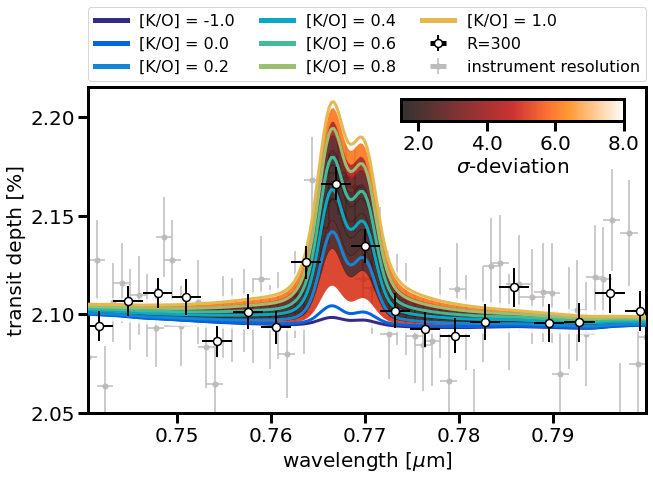

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
fig.set_facecolor('w')

cax = ax.inset_axes([0.56, 0.73, 0.4, 0.4])

cutends = 15
R=300

q = data['quality']==0
ax.errorbar(data['wave'][q], data['dppm'][q]/1e6, 
         xerr=data['wave_error'][q],
         yerr=data['dppm_err'][q]/1e6,
         linestyle='', marker='o',
         markeredgecolor='k',
         ecolor='k', ms=8, lw=2,
         markeredgewidth=1.5,
         color='w', zorder=200, label='R=300')

irc = '#bdbbba'
ax.errorbar(full[:,0], full[:,2], 
         xerr=full[:,1],
         yerr=full[:,3],
         linestyle='', marker='o',
         markeredgecolor=irc,
         ecolor=irc,
         color=irc, zorder=0, label='instrument resolution')



inds = np.linspace(0,200,len(models),dtype=int)
idx_y = np.array([])

for i, fn in enumerate(models):
    if i > 0:
        m0 = convolve_model(models[i-1], R=R)
        
    m1 = convolve_model(models[i], R=R)
    
    if i < len(models)-1:
        m2 = convolve_model(models[i+1], R=R)
    
    idx = (np.abs(np.array(chi_arr) - (ko_chi2[i]/1.13))).argmin()
    colorVal = scalarMap.to_rgba(idx)
    idx_y = np.append(idx_y, idx)
    
    
    if i % 2 == 0:
        lw = 3
        label='[K/O] = {}'.format(np.round(ko_labels[i],1))
    else:
        lw = 0
        label=''
        
    ax.plot(m1[0][cutends:-cutends], m1[1][cutends:-cutends],
             color=parula[inds[i]],
             lw=lw, label=label, zorder=4)
    
    alpha=0.8
    lw=0.4
    
    if i > 0 and i < len(models)-1:
        ax.fill_between(m1[0][cutends:-cutends], 
                         (m0[1][cutends:-cutends]+m1[1][cutends:-cutends])/2.0,
                         (m1[1][cutends:-cutends]+m2[1][cutends:-cutends])/2.0,
                         zorder=1, color=colorVal, alpha=alpha,
                         lw=lw)
        
    elif i == 0:
        ax.fill_between(m1[0][cutends:-cutends], 
                         m1[1][cutends:-cutends]-0.00003,
                         (m1[1][cutends:-cutends]+m2[1][cutends:-cutends])/2.0,
                         zorder=1, color=colorVal, alpha=alpha,
                         lw=lw)
        
    elif i == len(models)-1:
        ax.fill_between(m1[0][cutends:-cutends], 
                         (m0[1][cutends:-cutends]+m1[1][cutends:-cutends])/2.0,
                         m1[1][cutends:-cutends]+0.00003,
                         zorder=0, color=colorVal, alpha=alpha,
                         lw=lw)


ax.set_xlim(full[:,0][0], full[:,0][-1])
ax.set_xlabel('wavelength [$\mu$m]')
ax.set_ylabel('transit depth [%]')

yticks = np.round(np.arange(0.0205, 0.0230, 0.0005),4)
ax.set_yticks(yticks)
labels = np.round(yticks*100,2)
labels = [format(i, '.2f') for i in labels]
ax.set_yticklabels(labels)
ax.set_ylim(0.0205,0.02215)

cmin = 1.5
cmax = 8.0
cax.imshow(np.full((30,300), 
                   np.linspace(cmin, cmax,300)), 
           cmap=cmap_name, alpha=alpha)

sort = np.argsort(idx_y)
fit = interp1d(np.linspace(cmin, cmax, 300), 
               np.arange(0,300,1))

ticks = np.arange(2, 10, 2.0)
cax.set_xticks(fit(ticks))
cax.set_xticklabels(np.round(ticks,2))
cax.set_yticks([])

cax.set_xlabel(r'$\sigma$-deviation')
cax.yaxis.set_label_position("right")

leg = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                 ncol=3, mode="expand", borderaxespad=0., 
                 fontsize=16)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

plt.subplots_adjust(wspace=0.05) 
    
#plt.savefig('/Users/belugawhale/Documents/niriss_real/wasp39/paper_figures/potassium.pdf',
            #'/Users/belugawhale/Desktop/potassium_R{}.png'.format(R),
#           dpi=300, rasterize=True, bbox_inches='tight')

# Take two

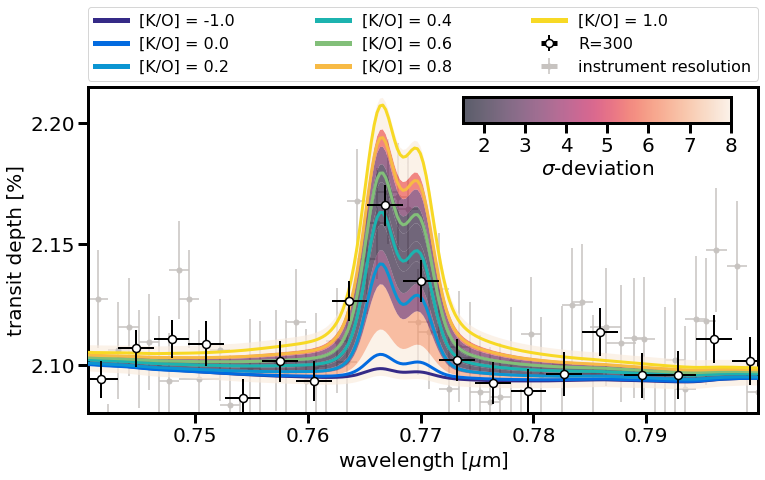

In [18]:
cmap_name = 'YlOrBr_r'

cmap_name = sns.color_palette("rocket", as_cmap=True)

CMAP = plt.get_cmap(cmap_name)
new_cmap= truncate_colormap(CMAP , 0.1, 2.0)
chi_arr=np.arange(1., 9, 0.1)
cNorm  = colors.Normalize(vmin=1, vmax=12)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=new_cmap)


fig, ax = plt.subplots(figsize=(12,6))
fig.set_facecolor('w')

cax = ax.inset_axes([0.56, 0.73, 0.4, 0.4])

cutends = 15
R=300

q = data['quality']==0
ax.errorbar(data['wave'][q], data['dppm'][q]/1e6, 
         xerr=data['wave_error'][q],
         yerr=data['dppm_err'][q]/1e6,
         linestyle='', marker='o',
         markeredgecolor='k',
         ecolor='k', ms=8, lw=2,
         markeredgewidth=1.5,
         color='w', zorder=200, label='R=300')

ax.errorbar(full[:,0], full[:,2], 
         xerr=full[:,1],
         yerr=full[:,3],
         linestyle='', marker='o',
         markeredgecolor='#c7c3c0',
         ecolor='#c7c3c0',
         color='#c7c3c0', zorder=0, label='instrument resolution')


inds = np.linspace(0,235,len(models),dtype=int)
inds[-3] = 210
idx_y = np.array([])

rocket = sns.color_palette("rocket", 7)
r = 0

for i, fn in enumerate(models):
    if i > 0:
        m0 = convolve_model(models[i-1], R=R)
        
    m1 = convolve_model(models[i], R=R)
    
    if i < len(models)-1:
        m2 = convolve_model(models[i+1], R=R)
    
    idx = (np.abs(np.array(chi_arr) - (ko_chi2[i]/1.3))).argmin()
    colorVal = scalarMap.to_rgba(idx)
    idx_y = np.append(idx_y, idx)
    
    
    if i % 2 == 0:
        lw = 3
        label='[K/O] = {}'.format(np.round(ko_labels[i],1))
    else:
        lw = 0
        label=''
        r += 1
        
    ax.plot(m1[0][cutends:-cutends], m1[1][cutends:-cutends],
             color=parula[inds[i]],
             lw=lw, label=label, zorder=100)
    
    alpha=0.65
    lw=0.0
    
    if i > 0 and i < len(models)-1:
        ax.fill_between(m1[0][cutends:-cutends], 
                         (m0[1][cutends:-cutends]+m1[1][cutends:-cutends])/2.0,
                         (m1[1][cutends:-cutends]+m2[1][cutends:-cutends])/2.0,
                         zorder=1, color=colorVal, alpha=alpha,
                         lw=lw)
        
    elif i == 0:
        ax.fill_between(m1[0][cutends:-cutends], 
                         m1[1][cutends:-cutends]-0.00003,
                         (m1[1][cutends:-cutends]+m2[1][cutends:-cutends])/2.0,
                         zorder=1, color=colorVal, alpha=alpha,
                         lw=lw)
        
    elif i == len(models)-1:
        ax.fill_between(m1[0][cutends:-cutends], 
                         (m0[1][cutends:-cutends]+m1[1][cutends:-cutends])/2.0,
                         m1[1][cutends:-cutends]+0.00003,
                         zorder=0, color=colorVal, alpha=alpha,
                         lw=lw)


ax.set_xlim(full[:,0][0], full[:,0][-1])
ax.set_xlabel('wavelength [$\mu$m]')
ax.set_ylabel('transit depth [%]')

yticks = np.round(np.arange(0.0205, 0.0230, 0.0005),4)
ax.set_yticks(yticks)
labels = np.round(yticks*100,2)
labels = [format(i, '.2f') for i in labels]
ax.set_yticklabels(labels)
ax.set_ylim(0.0208,0.02215)

cmin = 1.5
cmax = 8.0
cax.imshow(np.full((30,300), 
                   np.linspace(cmin, cmax,300)), 
           cmap=cmap_name, alpha=alpha)

sort = np.argsort(idx_y)
fit = interp1d(np.linspace(cmin, cmax, 300), 
               np.arange(0,300,1))

ticks = np.arange(2, 9, 1,dtype=int)
cax.set_xticks(fit(ticks))
cax.set_xticklabels(np.round(ticks,2))
cax.set_yticks([])

cax.set_xlabel(r'$\sigma$-deviation')
cax.yaxis.set_label_position("right")

leg = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                 ncol=3, mode="expand", borderaxespad=0., 
                 fontsize=16)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

plt.subplots_adjust(wspace=0.05) 
    
plt.savefig('/Users/belugawhale/Documents/niriss_real/wasp39/paper_figures/potassium.pdf',
            #'/Users/belugawhale/Desktop/potassium_R{}.png'.format(R),
           dpi=300, rasterize=True, bbox_inches='tight')

In [269]:
inds

array([  0,  20,  41,  62,  83, 104, 125, 145, 166, 187, 208, 229, 250])

In [219]:
t.as_hex()[6]

'#f6bc99'